# Emotion recognition Convolution Neural Network and fer2013 dataset

FER2013 is a large, publicly available Face Expression Recognition(FER) dataset consisting of 35,887 face crops. The dataset is challenging as the depicted faces vary significantly in terms of person age, face pose, and other factors, reflecting realistic conditions. The dataset is split into training, validation, and test sets samples. All images are grayscale i.e. only 1 channel and have a resolution of 48 by 48 pixels. Basic expression labels are provided for all samples.The goal is to categorize the emotions into the following seven categories:
- Angry
- Disgust
- Fear
- Happy
- Sad
- Surprise
- Neutral

### Loading  data from csv

In [1]:
import pandas as pd
data = pd.read_csv('./fer2013.csv')

### Data sampling and pre-processing

In [2]:
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:
print(data.shape)

(35887, 3)


In [4]:
print('Samples distribution Usage:')
print(data.Usage.value_counts())

Samples distribution Usage:
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


In [5]:
print('Samples per emotion:')
print(data.emotion.value_counts())

Samples per emotion:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [6]:
print('Number of pixels for a sample:')
print(len(data.pixels[0].split(' ')))

width, height = 48, 48

Number of pixels for a sample:
2304


#### Extracting data to faces and emotions arrays

In [7]:
import cv2
import numpy as np


pixels = data['pixels'].tolist() 

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] 
    face = np.asarray(face).reshape(width, height) 
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) 

emotions = pd.get_dummies(data['emotion']).values 

# Normalizing the RGB codes
faces /= 255

In [8]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [9]:
import matplotlib.pyplot as plt
id = 2
plt.imshow(faces[id].reshape(48,48), cmap="gray")
plt.title(emotion_dict[np.where(emotions[id]==1)[0][0]])

Text(0.5, 1.0, 'Fear')

Text(0.5, 1.0, 'Angry')

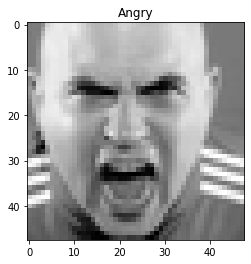

In [10]:
id = 22
plt.imshow(faces[id].reshape(48,48), cmap="gray")
plt.title(emotion_dict[np.where(emotions[id]==1)[0][0]])

Text(0.5, 1.0, 'Neutral')

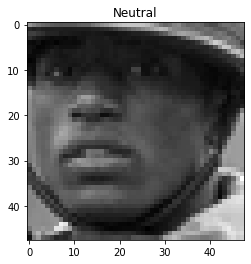

In [11]:
id = 222
plt.imshow(faces[id].reshape(48,48), cmap="gray")
plt.title(emotion_dict[np.where(emotions[id]==1)[0][0]])

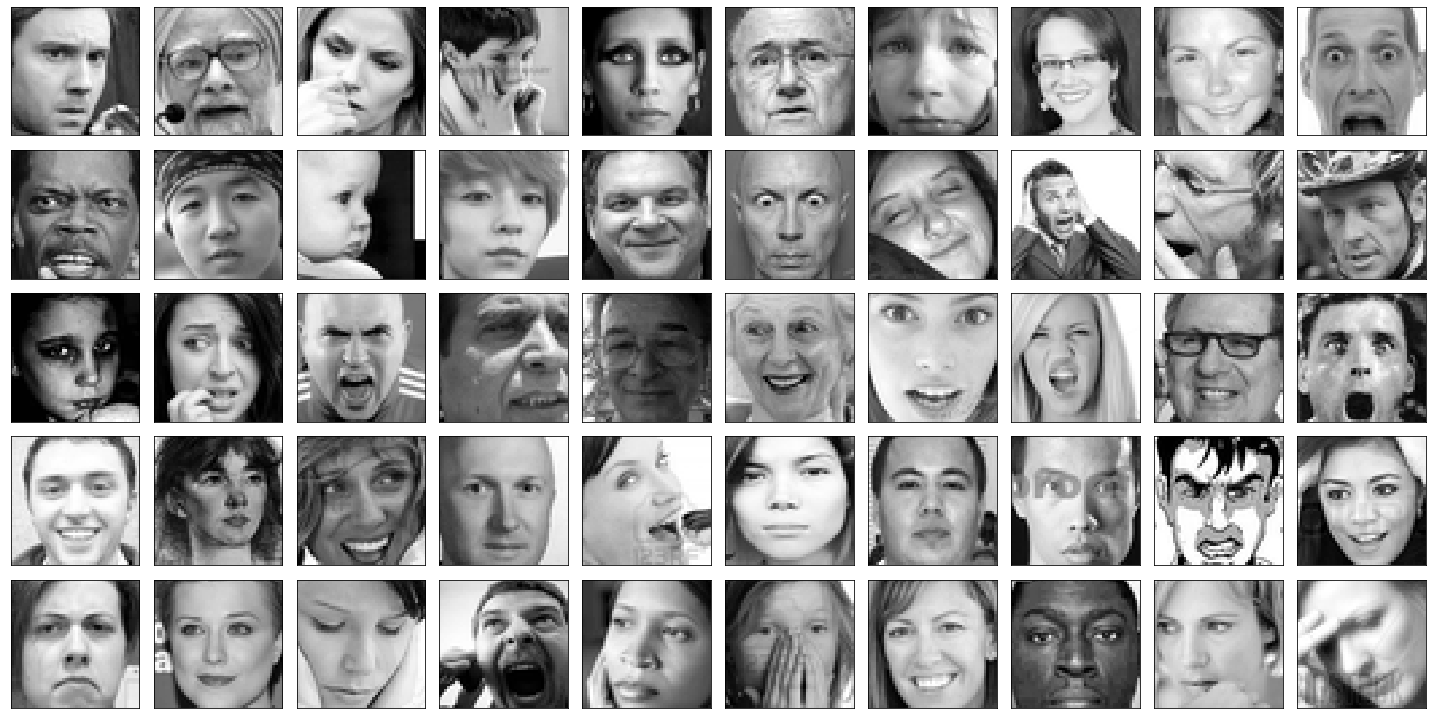

In [12]:
import matplotlib
import matplotlib.pyplot as plt

def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,50, faces)

In [13]:
faces.shape

(35887, 48, 48, 1)

In [14]:
emotions.shape

(35887, 7)

###  Split into train, test and validation set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [16]:
print(X_train.shape)
print(y_train.shape)

(29068, 48, 48, 1)
(29068, 7)


In [17]:
print(X_val.shape)
print(y_val.shape)

(3230, 48, 48, 1)
(3230, 7)


In [18]:
print(X_test.shape)
print(y_test.shape)

(3589, 48, 48, 1)
(3589, 7)


### Building CNN architecture

In [19]:
import sys, os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [34]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 10

In [21]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1),
                 data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4*num_features, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_features, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(num_labels, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

In [23]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [24]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [25]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [26]:
MODELPATH = './models/model.h5'

In [27]:
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

In [28]:
run_hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer]
          )

Train on 29068 samples, validate on 3589 samples
Epoch 1/10
29068/29068 [==============================] - 490s 17ms/step - loss: 1.9410 - accuracy: 0.2270 - val_loss: 1.7307 - val_accuracy: 0.2873

Epoch 00001: val_loss improved from inf to 1.73074, saving model to ./models/model.h5
Epoch 2/10
29068/29068 [==============================] - 505s 17ms/step - loss: 1.7360 - accuracy: 0.2967 - val_loss: 2.2441 - val_accuracy: 0.2499

Epoch 00002: val_loss did not improve from 1.73074
Epoch 3/10
29068/29068 [==============================] - 499s 17ms/step - loss: 1.6156 - accuracy: 0.3627 - val_loss: 1.5200 - val_accuracy: 0.4079

Epoch 00003: val_loss improved from 1.73074 to 1.52000, saving model to ./models/model.h5
Epoch 4/10
29068/29068 [==============================] - 490s 17ms/step - loss: 1.5180 - accuracy: 0.4082 - val_loss: 1.5423 - val_accuracy: 0.3809

Epoch 00004: val_loss did not improve from 1.52000
Epoch 5/10
29068/29068 [==============================] - 498s 17ms/step 

### Model evaluation

In [29]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

3589/3589 [==============================] - 19s 5ms/step
Loss: 1.2661200376166777
Accuracy: 0.530231237411499


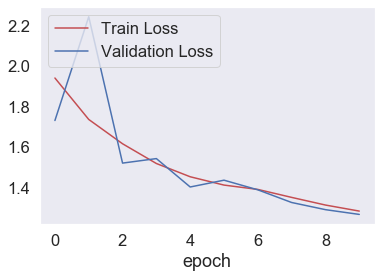

In [37]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

[Text(61.421875, 0.5, 'True label'), Text(0.5, 61.421875, 'Predicted label')]

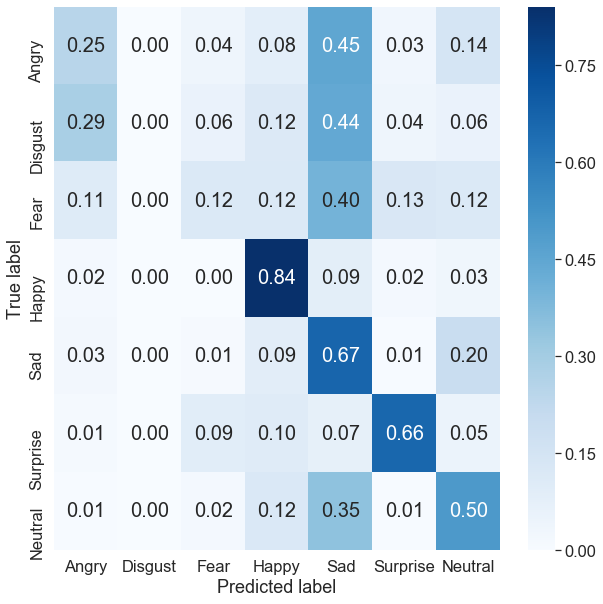

In [31]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                    cmap="Blues", yticklabels=emotion_labels, xticklabels=emotion_labels, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

### Change parameter optimizer from Adam to SGD

In [63]:
from keras.optimizers import SGD

In [64]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1),
                 data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4*num_features, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_features, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(num_labels, activation='softmax'))

In [65]:
model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.05),
              metrics=['accuracy'])

In [66]:
run_hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer]
          )

Train on 29068 samples, validate on 3589 samples
Epoch 1/10
29068/29068 [==============================] - 515s 18ms/step - loss: 1.9166 - accuracy: 0.2354 - val_loss: 1.8190 - val_accuracy: 0.2485

Epoch 00001: val_loss did not improve from 1.26612
Epoch 2/10
29068/29068 [==============================] - 519s 18ms/step - loss: 1.8132 - accuracy: 0.2534 - val_loss: 1.7958 - val_accuracy: 0.2513

Epoch 00002: val_loss did not improve from 1.26612
Epoch 3/10
29068/29068 [==============================] - 510s 18ms/step - loss: 1.7512 - accuracy: 0.2912 - val_loss: 1.6800 - val_accuracy: 0.3227

Epoch 00003: val_loss did not improve from 1.26612
Epoch 4/10
29068/29068 [==============================] - 512s 18ms/step - loss: 1.6965 - accuracy: 0.3202 - val_loss: 1.7003 - val_accuracy: 0.2979

Epoch 00004: val_loss did not improve from 1.26612
Epoch 5/10
29068/29068 [==============================] - 506s 17ms/step - loss: 1.6504 - accuracy: 0.3444 - val_loss: 1.7542 - val_accuracy: 0.291

In [67]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

3589/3589 [==============================] - 17s 5ms/step
Loss: 1.547667916122005
Accuracy: 0.3911953270435333


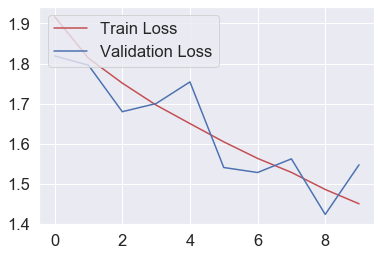

In [70]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

[Text(61.421875, 0.5, 'True label'), Text(0.5, 61.421875, 'Predicted label')]

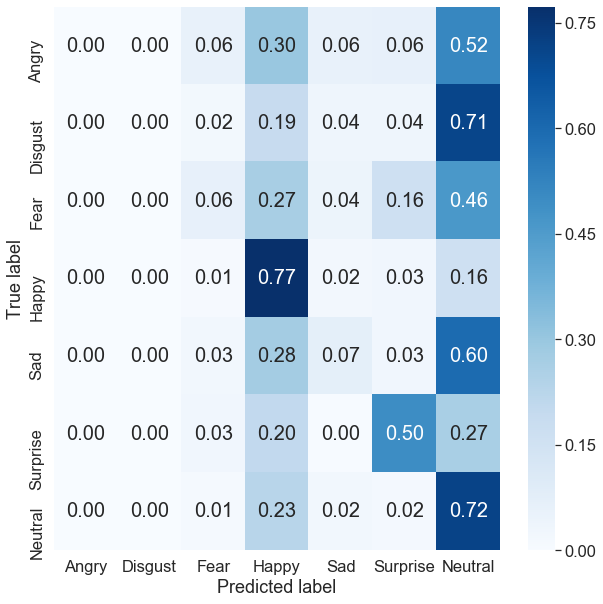

In [71]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                    cmap="Blues", yticklabels=emotion_labels, xticklabels=emotion_labels, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')